In [1]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
from config.params import FusionParams
from config.initialize_simulation import initialize_state
from model.agents_class import AgentStake
from model.rewards import calculate_reward_allocation
from model.stochastic_processes import create_stochastic_avail_price_process, plot_price

from real_data_fetcher import fetch

from config.psub import psub


# Price Traj Generation

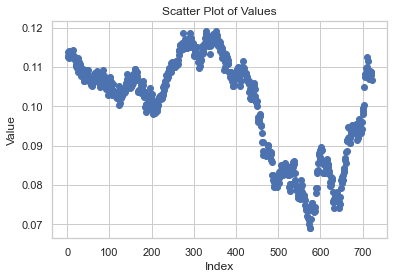

0.0689519290350078


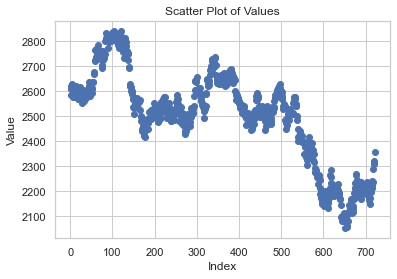

2051.2474716920856


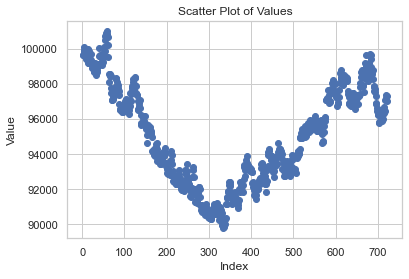

89771.92693936577


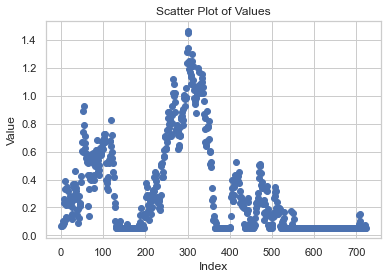

0.05


In [4]:
# types
Run = int
Timestep = int

avl_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0)


# from config.config import (
#     TIMESTEPS,
#     DELTA_TIME,
# )
# avl_price_samples = [0.1] * TIMESTEPS

plot_price(avl_price_samples)
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=1500, target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples)
print(min(eth_price_samples))

btc_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=65000, target_avg=95000, maximum_avl_price=110000)
plot_price(btc_price_samples)
print(min(btc_price_samples))

lens_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.3, maximum_avl_price=2, volatility=3.0)
plot_price(lens_price_samples)
print(min(lens_price_samples))


In [5]:
# avl_price_samples, eth_price_samples, Timestep = fetch(symbol_avl='hawk')

# plot_price(avl_price_samples) 
# print(min(avl_price_samples))

# plot_price(eth_price_samples) 
# print(min(eth_price_samples))

# Setup

In [6]:
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.11259019257342207


In [7]:
# Fixed parameters
def fixed_params(total_supply = 10_000_000_000, avl_price = AVL_initial_price):
    total_fdv = total_supply * avl_price
    return total_fdv

init_total_fdv = fixed_params(avl_price = AVL_initial_price)



In [8]:
constants = {
    "total_supply": 10_000_000_000,
    "init_total_fdv": init_total_fdv,
    "native_staking_ratio": 0.5,
    "upper_rewards_to_fusion_pct": 0.5
}




In [9]:
## create maxi agents

agents = AgentStake.create_maxi_agents(
    target_composition={'AVL': 0, 'ETH': 1, 'BTC': 0},  # 50% AVL, 30% ETH, 20% BTC
    total_tvl=1  # $1M total TVL
)

In [10]:
rewards_result = calculate_reward_allocation(
    constants=constants,
    avl_price=0.1,
    total_tvl=250e6,
    avl_stake_pct=0.15,
    target_avl_yield=0.15,
    target_eth_yield=0.035
)

assert rewards_result["capped"] == False


fusion_pct: 0.26125


# Simulation

In [11]:
# system parameters
parameters = FusionParams(
    constants=[constants],  # Wrap in list for multiple runs
    avl_price_samples=[avl_price_samples],  # List of price trajectories
    eth_price_samples=[eth_price_samples],
    btc_price_samples=[btc_price_samples],
    lens_price_samples=[lens_price_samples],
    rewards_result=[rewards_result],  # List of reward results
    agents=[agents],  # List of agent configurations
    btc_activation_day=[180]
).__dict__

params = parameters


In [12]:
# initial conditions

initial_conditions = {
    "timestep": 0,
    
    # security shares
    "total_security": 0,
    "total_fdv": init_total_fdv,

    # staking ratios
    "staking_ratio_all": constants["native_staking_ratio"],
    "staking_ratio_fusion": {'AVL': 0, 'ETH': 0},

    # inflation and rewards metrics
    "inflation_rate": rewards_result["init_inflation_rate"],
    "total_annual_inflation_rewards_in_avl": rewards_result["total_inflation_rewards_in_avl"],
    "total_annual_inflation_rewards_usd": rewards_result["total_inflation_rewards_usd"],

    # agent states
    "agents": agents, # include token prices

    # yield metrics
    "avg_yield": 0,
    "yield_pcts": {"avl_maxi": 0, "eth_maxi": 0},

    # admin params
    "fusion_palette_remaining": {'AVL': 0, 'ETH': 0},
    "target_yields": {'AVL': 0.15, 'ETH': 0.035},
}



initial_conditions = initialize_state(init_total_fdv, constants, rewards_result, 0)


In [13]:
# Add validation checks
assert len(parameters['avl_price_process']) == 1, "Should have 1 price process"
assert parameters['avl_price_process'][0](0) == avl_price_samples[0], "Price mismatch"
#assert 'run' in initial_conditions, "Missing run key in initial state"



In [14]:
avl_agent = agents['avl_maxi']
avl_agent.total_tvl
avl_agent.add_rewards(100)

In [15]:
# run simulation

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

simulation=Simulation(model=model, timesteps=600, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results  = experiment.run()
df= pd.DataFrame(results)


###########################
timestep 0
[DEBUG] update_token_prices
{'avl_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=np.float64(1.0), balance=6.999999999999999, price=np.float64(0.11259019257342207)), 'ETH': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(2586.210418747756)), 'BTC': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(99662.66522227944))}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0), 'eth_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(0.11259019257342207)), 'ETH': AssetAllocation(pct=np.float64(1.0), balance=9.999999999999999e-05, price=np.float64(2586.210418747756)), 'BTC': AssetAllocation(pct=np.float64(0.0), balance=0, price=np.float64(99662.66522227944))}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0), 'btc_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=np.float64(0.11259019257342207)), 'ETH': AssetAllocation(pct=0.0, balance=0, price=np.

In [16]:
print(df)
df.to_csv('simulation_results.csv', index=False, encoding='utf-8')

      timestep                                             agents  \
0            0  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
1            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
2            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
3            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4            1  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
...        ...                                                ...   
4196       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4197       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4198       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4199       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   
4200       600  {'avl_maxi': AgentStake(assets={'AVL': AssetAl...   

                                           pool_manager  \
0     PoolManager(total_budget=30000000.0, pools={'A...   
1     PoolManager(total_budget=30000000.0, pools={'A.

In [17]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
        0: "downside",
    }
)

In [18]:
fig= visualizations.plot_total_security(
    df
)
pio.show(fig)

In [19]:
fig = visualizations.plot_avg_overall_yield(
    df
)
pio.show(fig)


In [20]:
fig = visualizations.plot_yield_pct(
    df
)
pio.show(fig)

In [21]:
fig= visualizations.plot_staking_ratio_inflation_rate(
    df,
    assets=['AVL', 'ETH', 'BTC']
)
pio.show(fig)
